In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# matplot 한글
font_name = matplotlib.font_manager.FontProperties(
                fname="C:/Windows/Fonts/NanumGothic.ttf"
            ).get_name()
matplotlib.rc('font', family=font_name)

In [2]:
# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["피고인 경찰 체포 범죄",
             "살인죄 검사 기소 증거 기각 석방",
             "상해죄 검사 기소 징역 선고 전치",
             "피해자 용의자 피의자 피고인 변호인",
             "피의자 범인 경찰",
             "변호인 피고인 책임 감경",
             "살인죄 칼 살해 살인 피해자 유족 충격",
             "피해자 사과 피해보상 고통",
             "피의자 용의자 범죄 혐의 수사 법원",
             "피고인 법원 공소제기",
             "판사 검사 기각 인용 판결 항소",
             "증거 자수 감경 책임 부당",
             "칼 위험 피해자",
             "위험 상해죄 전치",
             "경찰 자수 감경"]

# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트 만듬.
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만든다.
word_dict = {w: i for i, w in enumerate(word_list)}

# 윈도우 사이즈를 1 로 하는 skip-gram 모델
# 예측하는 단어들은 현재 단어 주위에서 샘플링. 기준단어의 양쪽 단어 쌍(윈도우 사이즈 1이니 1칸씩 이동가능)
# 예) 피해자 사과 피해보상 고통
#   -> (피해자,사과),(사과,피해자),(사과 피해보상),(피해보상, 사과),(피해보상,고통),(고통,피해보상)
skip_grams = []

for i in range(1, len(word_sequence) - 1): 
    # (context, target) : ([target index - 1, target index + 1], target)
    # 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]] 

    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])


# 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수(미니배치)
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels

loss at step  10 :  12.119287
loss at step  20 :  7.897191
loss at step  30 :  4.7616863
loss at step  40 :  4.1983457
loss at step  50 :  3.743489
loss at step  60 :  3.7236462
loss at step  70 :  3.5996716
loss at step  80 :  3.1809688
loss at step  90 :  3.1675758
loss at step  100 :  4.036414
loss at step  110 :  3.2205443
loss at step  120 :  3.5190365
loss at step  130 :  3.1699882
loss at step  140 :  2.9704432
loss at step  150 :  2.788768
loss at step  160 :  3.0821667
loss at step  170 :  4.3097754
loss at step  180 :  3.16258
loss at step  190 :  3.4777355
loss at step  200 :  3.2345014
loss at step  210 :  2.883377
loss at step  220 :  3.0863957
loss at step  230 :  2.9762363
loss at step  240 :  2.8165634
loss at step  250 :  3.2013817
loss at step  260 :  3.2768722
loss at step  270 :  3.0590405
loss at step  280 :  3.31711
loss at step  290 :  3.0037618
loss at step  300 :  4.033798


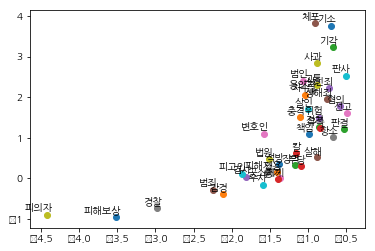

In [4]:
#########
# 옵션 설정
######
# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기(미니배치)
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 2차원으로 구성하여 시각화하기 편하도록 만듬.
embedding_size = 2
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 함.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)


#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야 한다고.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 가짐.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행 추출
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]

# 단어를 벡터로 매핑시킴.
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss(Noise-Constratrive Estimation) 이용. batch의 평균 NCE loss를 계산한다.
# tf.nce_loss 함수는 loss를 평가(evaluate)할 때마다 negative labels을 가진 새로운 샘플을 자동적으로 생성한다.
# 쉽게 설명하자면 .... 학습시간을 줄이기 위해서 윈도우 사이즈에 포함되지 않은 단어로 쌍을 구성하는 것.
# 진짜 데이터쌍(윈도우 내의 데이터쌍)과 가짜 데이터쌍을 섞어 학습하고, 이 두개를 구분할 수 있는 바이너리 분류기를 학습시킴.
# 이 분류기에서 학습된 가중치 벡터가 바로 워드 임베딩.
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

# GD방식
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


#########
# 신경망 모델 학습
######
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)

    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용가능.
    trained_embeddings = embeddings.eval()


#########
# 임베딩된 Word2Vec 결과 확인
# 단어들끼리의 연관성.
######
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

# 3분 딥러닝 책 일부 참고.